In [1]:
%load_ext lab_black
%matplotlib inline

# Introduction

Hello, and welcome to the signal processing repository! You are probably here because you've seen the following graphs in [Evergreen](https://github.com/evergreen-ci/evergreen) (e.g. [here](https://evergreen.mongodb.com/task/performance_linux_wt_repl_pipeline_updates_cbead440945c78b577c29dab8c11e81a58ee7731_19_07_17_14_49_15)), and are wondering how they are generated:  
  
![Evergreen Graph](assets/evergreen_graph.png)

Let's take a deep dive and see what's going on behind the scenes. Once we're through, you should understand the nomenclature and functionality at play and be able to contribute your own code to this repo!

## Prerequisites

Before going any further, you should be familiar with how MongoDB works, either through New Hire Technical Training, or otherwise. Additionally, you should have access to our [Atlas cluster](https://cloud.mongodb.com/v2/5ad0ab11c0c6e30f62c1c56a#clusters/detail/PerformanceData) (don't forget to whitelist your IP!) in order to get a copy of the performance data to play with, as well as a Python2 installation. [Jupyter Lab/Notebook](https://jupyter.org/) is also highly recommended if you want to execute the python code in this guide directly while following along! If you are following along, set up Juypter Lab using Python3, and then add a Python2 kernel using the following:

```
$ python2 -m pip install ipykernel
$ python2 -m ipykernel install --user
```

Once this is set up, you can run this introduction yourself using:
```
$ juypter lab $SIGNAL_PROCESSING_REPO/docs/intro.ipynb
```

If you would like to make modifications to this readme, please do so by updating the `signal_processing/docs/readme.ipynb` file and compiling out a new markdown file using:
```
$ jupyter nbconvert intro.ipynb --to markdown --TagRemovePreprocessor.remove_cell_tags='{"hide_cell"}'
```

You can hide cells by setting their cell metadata to:
```
{
    "tags": [
        "hide_cell"
    ]
}
```

## Getting the Data

First, let's make a working directory to play with stuff:

```
$ mkdir signal_processing_intro
$ cd signal_processing_intro
```

Now, let's get that data:

```
$ mongodump --host PerformanceData-shard-0/performancedata-shard-00-00-g6tsc.mongodb.net:27017,performancedata-shard-00-01-g6tsc.mongodb.net:27017,performancedata-shard-00-02-g6tsc.mongodb.net:27017 --ssl --username $YOUR_USERNAME --password $YOUR_PASSWORD --authenticationDatabase admin --db perf
```

And get it into a local db:

```
$ mkdir db
$ mongod --port 27017 --dbpath ./db --logpath ./db/log.txt --fork
$ mongorestore --port 27017 dump
```

##  Taking a Tour

Let's take a tour of the database we've just cloned:

```
$ mongo
MongoDB shell version v4.0.10
connecting to: mongodb://127.0.0.1:27017/?gssapiServiceName=mongodb
Implicit session: session { "id" : UUID("7a69da97-3b32-49f3-a1ae-61dfbb2dade4") }
MongoDB server version: 4.0.10
Server has startup warnings:
2019-07-17T15:56:13.450-0400 I CONTROL  [initandlisten]
2019-07-17T15:56:13.450-0400 I CONTROL  [initandlisten] ** WARNING: Access control is not enabled for the database.
2019-07-17T15:56:13.450-0400 I CONTROL  [initandlisten] **          Read and write access to data and configuration is unrestricted.
2019-07-17T15:56:13.450-0400 I CONTROL  [initandlisten]
2019-07-17T15:56:13.450-0400 I CONTROL  [initandlisten] ** WARNING: This server is bound to localhost.
2019-07-17T15:56:13.450-0400 I CONTROL  [initandlisten] **          Remote systems will be unable to connect to this server.
2019-07-17T15:56:13.450-0400 I CONTROL  [initandlisten] **          Start the server with --bind_ip <address> to specify which IP
2019-07-17T15:56:13.450-0400 I CONTROL  [initandlisten] **          addresses it should serve responses from, or with --bind_ip_all to
2019-07-17T15:56:13.450-0400 I CONTROL  [initandlisten] **          bind to all interfaces. If this behavior is desired, start the
2019-07-17T15:56:13.450-0400 I CONTROL  [initandlisten] **          server with --bind_ip 127.0.0.1 to disable this warning.
2019-07-17T15:56:13.450-0400 I CONTROL  [initandlisten]
MongoDB Enterprise > use perf
switched to db perf
MongoDB Enterprise > show collections
build_failures
change_points
change_points_with_attachments
group_unprocessed_change_points
linked_build_failures
marked_outliers
mute_outliers
outliers
points
processed_change_points
system.views
unprocessed_change_points
whitelisted_outlier_tasks
```

Our main point of interest is the `points` collection. It is basically the raw data that signal processing is being fed from Evergreen, from which change points (inflection points due to true changes in performance) and outliers (erroneous results) are calculated. We will worry about those later, since they are a surface for interaction with other teams, e.g. server engineers (people who build the server) and build barons (people who monitor these tests). Next, let's take a look at a data point from the same time series as our Evergreen example and see what we've got going on:

```
MongoDB Enterprise > db.points.findOne({"project": "performance", "variant": "linux-wt-repl", "task": "pipeline-updates", "test": "PipelineUpdate.IncWithIndex"})
{
    "_id" : ObjectId("5d036633be1a7ab91df16b6d"),
    "project" : "performance",
    "revision" : "bde7615a648ad9bacef680bc5144dcc8c308f6f4",
    "task" : "pipeline-updates",
    "test" : "PipelineUpdate.IncWithIndex",
    "variant" : "linux-wt-repl",
    "version_id" : "performance_bde7615a648ad9bacef680bc5144dcc8c308f6f4",
    "create_time" : "2019-06-13T16:21:46Z",
    "end" : "2019-06-14T08:51:24.418Z",
    "max_ops_per_sec" : 24277.45808882821,
    "max_thread_level" : 8,
    "order" : 17731,
    "results" : [
        {
            "thread_level" : "1",
            "ops_per_sec_values" : [
                6309.900910696832,
                6288.226479347127,
                6288.093141054716,
                6300.279945778754,
                6262.250566418394
            ],
            "ops_per_sec" : 6289.750208659165
        },
        {
            "thread_level" : "2",
            "ops_per_sec_values" : [
                11975.982039326771,
                11902.78105538512,
                11941.63157833687,
                11863.30718286052,
                11929.325212856527
            ],
            "ops_per_sec" : 11922.605413753163
        },
        {
            "thread_level" : "4",
            "ops_per_sec_values" : [
                22634.869882795923,
                22461.447820841186,
                22528.655544298348,
                22563.796531855718,
                22394.231021140695
            ],
            "ops_per_sec" : 22516.600160186375
        },
        {
            "thread_level" : "8",
            "ops_per_sec_values" : [
                24321.731721056578,
                24338.80145966017,
                24293.912303380137,
                24256.35230423948,
                24176.492655804686
            ],
            "ops_per_sec" : 24277.45808882821
        }
    ],
    "start" : "2019-06-14T08:49:42.592Z",
    "task_id" : "performance_linux_wt_repl_pipeline_updates_bde7615a648ad9bacef680bc5144dcc8c308f6f4_19_06_13_16_21_46",
    "workload" : "microbenchmarks"
}
```

A lot is going on here, but a few categories can be easily recognized if we reorganize the data a bit:

```
MongoDB Enterprise > match = {
    "$match": {
      "project": "performance",
      "variant": "linux-wt-repl",
      "task": "pipeline-updates",
      "test": "PipelineUpdate.IncWithIndex"
    }
  }
MongoDB Enterprise > projection = {
    "$project": {
      "test_identifier": {
        "project": "$project",
        "variant": "$variant",
        "task": "$task",
        "test": "$test"
      },
      "time": {
        "start": {
          "$toDate": "$start"
        },
        "end": {
          "$toDate": "$end"
        },
        "created": {
          "$toDate": "$create_time"
        }
      },
      "revision": {
        "hash": "$revision",
        "order": "$order"
      },
      "max_result": {
        "threads": "$max_thread_level",
        "value": "$max_ops_per_sec"
      },
      "results": {
        "$map": {
          "input": "$results",
          "as": "result",
          "in": {
            "threads": {
              "$toInt": "$$result.thread_level"
            },
            "value": "$$result.ops_per_sec"
          }
        }
      },
      "workload": "$workload"
    }
  }
MongoDB Enterprise > db.points.aggregate([match, {"$limit": 1}, projection]).pretty()
{
    "_id" : ObjectId("5d036633be1a7ab91df16b6d"),
    "revision" : {
        "hash" : "bde7615a648ad9bacef680bc5144dcc8c308f6f4",
        "order" : 17731
    },
    "test_identifier" : {
        "project" : "performance",
        "variant" : "linux-wt-repl",
        "task" : "pipeline-updates",
        "test" : "PipelineUpdate.IncWithIndex"
    },
    "time" : {
        "start" : ISODate("2019-06-14T08:49:42.592Z"),
        "end" : ISODate("2019-06-14T08:51:24.418Z"),
        "created" : ISODate("2019-06-13T16:21:46Z")
    },
    "max_result" : {
        "threads" : 8,
        "value" : 24277.45808882821
    },
    "results" : [
        {
            "threads" : 1,
            "value" : 6289.750208659165
        },
        {
            "threads" : 2,
            "value" : 11922.605413753163
        },
        {
            "threads" : 4,
            "value" : 22516.600160186375
        },
        {
            "threads" : 8,
            "value" : 24277.45808882821
        }
    ],
    "workload" : "microbenchmarks"
}
```

I've thrown out some data that is just repetition (`ops_per_sec_values` (gets averaged into `ops_per_sec`),`version_id`, `task_id` (both of these are for the UI)), and reformatted the rest so that it is clearer and has the appropriate types. Let's go over what's left:

* `revision` contains the git commit hash and chronological order of the commit
* `test_identifier` contains the fields identifying the test being run; Each project (e.g. `performance`, `sys-perf`, `performance-3.4`, etc.) can be run in different mongod setups (`variant`) in evergreen; Each `variant` can specify a `task` to run, consisting of multiple `test` runs\*
* `time` contains information regarding the scheduling, start, and end of the test run
* `max_result` is the highest performance result obtained during the test, and typically what is displayed in Evergreen
* `results` are all the results, considering the test is usually run with a variable amount of threads in parallel
* `workload` what kind of workload we are running, e.g. `microbenchmarks`, [`ycsb`](https://github.com/brianfrankcooper/YCSB), [`tpcc`](http://www.tpc.org/tpcc/)

\*As an example, we could induce the test we are looking at by scheduling a patch on evergreen with the following configuration:

```
$ evergreen patch -p performance -y -d sample-patch
Patch successfully created.

         ID : 5d308f645623432a7b1d3347
    Created : 2019-07-18 15:25:24.214 +0000 UTC
Description : <none>
      Build : https://evergreen.mongodb.com/patch/5d308f645623432a7b1d3347 <--- follow this link
     Status : created
  Finalized : No
```

![Patch Configuration](assets/patch_build.png)

## Visualizing the Data

Cool, so we've seen a data point. Now we want to see more. We should just remove the `{$limit: 1}` pipeline stage from our aggregation, right? No! We need graphs. Let's start by creating the graph we saw in our Evergreen example.

Before we start, make sure that your python kernel has the packages we will be using:
* pymongo
* pandas
* matplotlib
* numpy
* seaborn

Let's begin:

In [1]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from datetime import datetime
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# This will connect to our local mongod instance on the default port 27017
client = MongoClient()
db = client.perf

We want to only match data points for our selected type of test:

In [2]:
match = {
    "$match":
        {
            "project": "performance",
            "variant": "linux-wt-repl",
            "task": "pipeline-updates",
            "test": "PipelineUpdate.IncWithIndex",
        }
}

Project it like we did before:

In [3]:
projection = {
    "$project":
        {
            "test_identifier":
                {
                    "project": "$project",
                    "varaint": "$variant",
                    "task": "$task",
                    "test": "$test",
                },
            "time":
                {
                    "start": {
                        "$toDate": "$start"
                    },
                    "end": {
                        "$toDate": "$end"
                    },
                    "created": {
                        "$toDate": "$create_time"
                    },
                },
            "revision": {
                "hash": "$revision",
                "order": "$order"
            },
            "max_result":
                {
                    "threads": "$max_thread_level",
                    "value": "$max_ops_per_sec"
                },
            "results":
                {
                    "$map":
                        {
                            "input": "$results",
                            "as": "result",
                            "in":
                                {
                                    "threads":
                                        {
                                            "$toInt": "$$result.thread_level"
                                        },
                                    "value": "$$result.ops_per_sec",
                                },
                        }
                },
            "workload": "$workload",
        }
}

Only get the range of data corresponding to the Evergreen graph (6/28/2019 - 7/16/2019 at time of writing): 

In [4]:
date_match = {
    "$match":
        {
            "$and":
                [
                    {
                        "time.created": {
                            "$gte": datetime(2019, 6, 28)
                        }
                    },
                    {
                        "time.created": {
                            "$lte": datetime(2019, 7, 18)
                        }
                    },
                ]
        }
}

Only load the data we care about:

In [5]:
data_load = {"$project": {"y": "$max_result.value", 'date': '$time.created'}}

Sort it:

In [6]:
sort = {"$sort": {"x": 1}}

And finally, plot it:

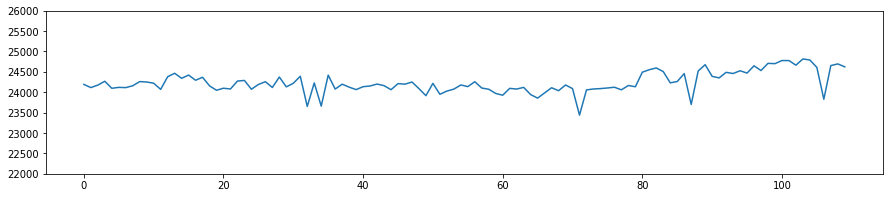

In [7]:
data = list(
    db.points.aggregate([match, projection, date_match, data_load, sort])
)
series = pd.Series([point["y"] for point in data])
indices = range(0, len(data))
fig = plt.figure(figsize=(15, 3))
ax = fig.add_subplot(111)
ax.set_ylim(22000, 26000)
result_plot = ax.plot(indices, series)

Let's also switch over to dates:

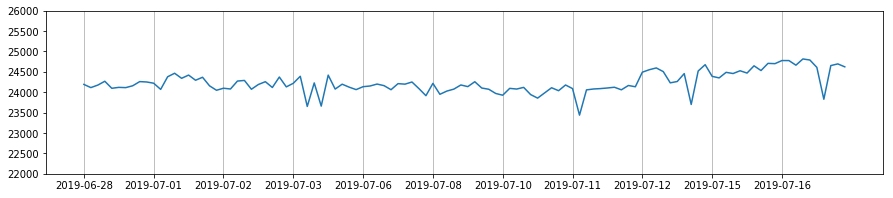

In [8]:
dates = pd.Series([point["date"] for point in data])
ticks = indices[::10]
tick_labels = [dates[tick].date() for tick in ticks]
ax.xaxis.grid(True)
x_ticks = ax.set_xticks(ticks)
x_tick_labels = ax.set_xticklabels(tick_labels)
fig

## Where are the change points?

Good question! We haven't calculated any yet, let's do that now. Make sure you are in the DSI repository base folder!

```
$ cd $PATH_TO_DSI
$ python2 -m pip install -e .
```

Now we can start processing our signal:

In [9]:
from signal_processing.change_points.e_divisive import EDivisive
from signal_processing.outliers.gesd import gesd
from bin.common.log import setup_logging
import logging

# Shhh...
setup_logging(explicit_log_level=logging.ERROR)

Before calculating change points, we'll probably want to weed out some outliers

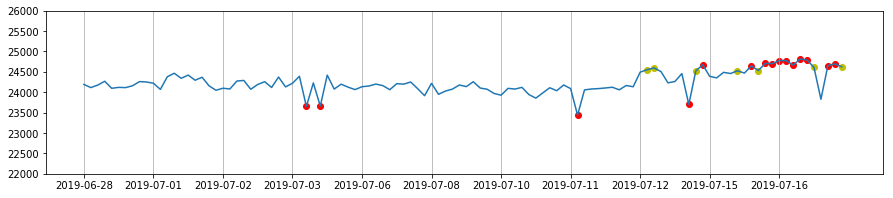

In [10]:
gesd_result = gesd(series, max_outliers=0.2 * len(series), mad=True)
outliers = np.array(gesd_result.suspicious_indexes[:gesd_result.count])
low_confidence_outliers = gesd_result.suspicious_indexes[gesd_result.count:]
outliers_scatter = ax.scatter(
    outliers, [series[outlier] for outlier in outliers], color='r'
)
low_confidence_outliers_scatter = ax.scatter(
    low_confidence_outliers,
    [series[outlier] for outlier in low_confidence_outliers],
    color='y'
)
fig

Let's go ahead and mask these so our change point algorithm doesn't take them into account:

In [11]:
series_masked = np.ma.array(series)
series_masked.mask = np.array([False] * len(series))
series_masked.mask[outliers] = True
compressed_series = series_masked.compressed()

And compute some change points:

In [13]:
algorithm = EDivisive()
change_points = algorithm.compute_change_points(series)
change_points_with_mask = algorithm.compute_change_points(compressed_series)

And get their indices, correcting the masked change points since we compressed the input array:

In [14]:
change_point_indices = [change_point.index for change_point in change_points]
masked_change_point_indices = [
    change_point.index +
    len([1 for item in series_masked.mask[:change_point.index] if item])
    for change_point in change_points_with_mask
]

Let's plot our change points:

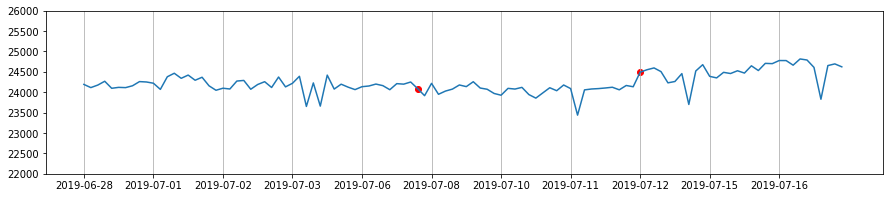

In [15]:
outliers_scatter.remove()
low_confidence_outliers_scatter.remove()
masked_cp = ax.scatter(
    masked_change_point_indices,
    [series[point] for point in masked_change_point_indices],
    color='r'
)
fig

Cool, let's take a (magnified) look if this roughly fits and makes sense:

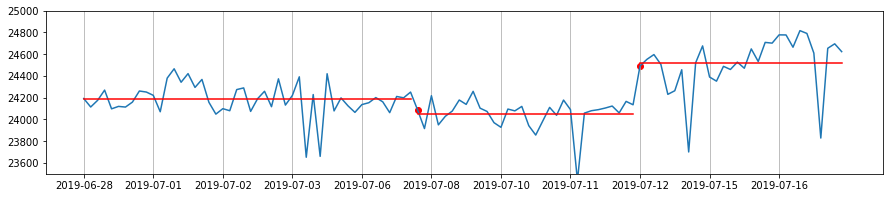

In [16]:
means = []
prev = 0
for idx in sorted(masked_change_point_indices):
    means.append(
        ax.plot(
            range(prev, idx), [np.mean(series[prev:idx])] * (idx - prev), 'r'
        )[0]
    )
    prev = idx
means.append(
    ax.plot(
        range(idx, len(series)),
        [np.mean(series[idx:len(series)])] * (len(series) - idx), 'r'
    )[0]
)
ax.set_ylim(23500, 25000)
fig

Looks pretty good!

One thing to bear in mind is that Evergreen uses a completely different framework for rendering these graphs, and there are many more parameters being used to configure these algorithms, so your results here may be significantly different:

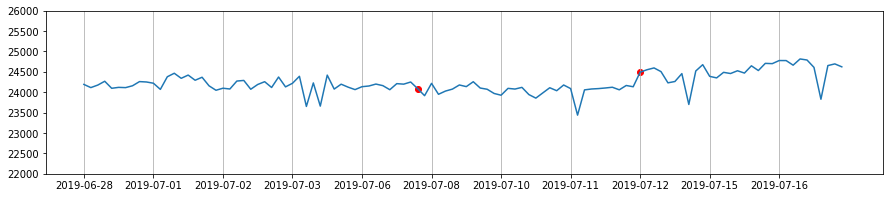

In [17]:
for mean in means:
    mean.remove()
ax.set_ylim(22000, 26000)
fig

vs  
  
![Evergreen Graph](assets/evergreen_graph.png)

##  Conclusion

Now you know a bit about how we calculate change points. Awesome! Feel free to play around in this notebook, and perhaps find alternative methods to analyze our data?

I'll provide some examples for a change we could make:

### An Example "New Idea" 

Let's look at our data's mean, and two of it's standard deviations:

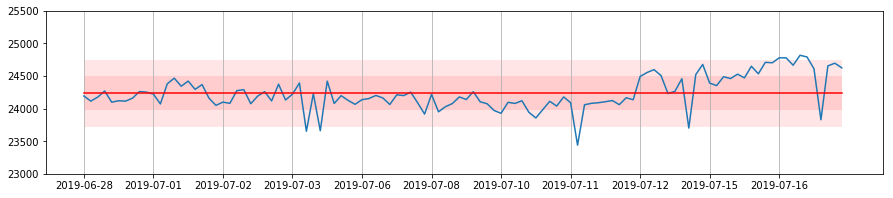

In [18]:
masked_cp.remove()
mean_plot = ax.plot(indices, [series.mean()] * len(indices), 'r')[0]
ax.set_ylim(23000, 25500)
std_1_plot = ax.fill_between(
    indices, [series.mean() + series.std()] * len(indices),
    [series.mean() - series.std()] * len(indices),
    facecolor='r',
    alpha=0.1
)
std_2_plot = ax.fill_between(
    indices, [series.mean() + 2 * series.std()] * len(indices),
    [series.mean() - 2 * series.std()] * len(indices),
    facecolor='r',
    alpha=0.1
)
fig

At first glance we might want to mark all points outside of two standard deviations as outliers. But this is not very useful, since the mean and deviation range is static, and the graph eventually drifts out of it altogether. Plus, do we recompute this for the whole range of data when we run a new test? Let's use a rolling mean and deviation instead:

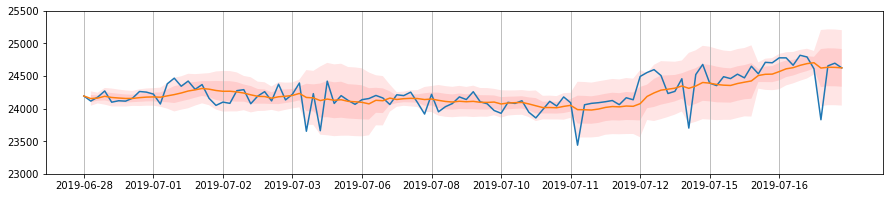

In [19]:
mean_plot.remove()
std_1_plot.remove()
std_2_plot.remove()

rolling_window = series.rolling(10, min_periods=1)

#mean
mean_plot = ax.plot(indices, rolling_window.mean())[0]

# 1st and 2st standard deviation interval
std_1_plot = ax.fill_between(
    indices,
    rolling_window.mean() + rolling_window.std(),
    rolling_window.mean() - rolling_window.std(),
    facecolor='r',
    alpha=0.1
)
std_2_plot = ax.fill_between(
    indices,
    rolling_window.mean() + 2 * rolling_window.std(),
    rolling_window.mean() - 2 * rolling_window.std(),
    facecolor='r',
    alpha=0.1
)
fig

That looks a bit better! we can pretty clearly see a few points that are quite different from their neighbors:

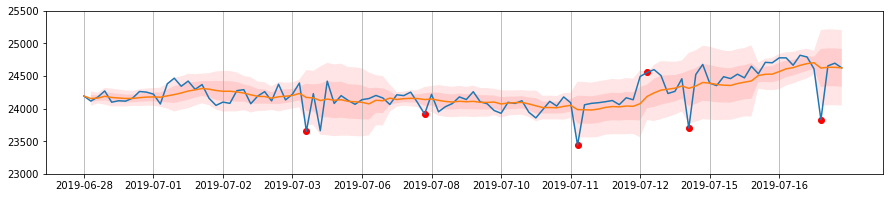

In [20]:
is_outlier = np.abs(series - rolling_window.mean()) > 2 * rolling_window.std()
outlier_indices = [index for index, value in enumerate(is_outlier) if value]
new_outliers = ax.scatter(
    outlier_indices, series[outlier_indices], facecolor='r'
)
fig

Let's get rid of these outliers and calculate change points like before:

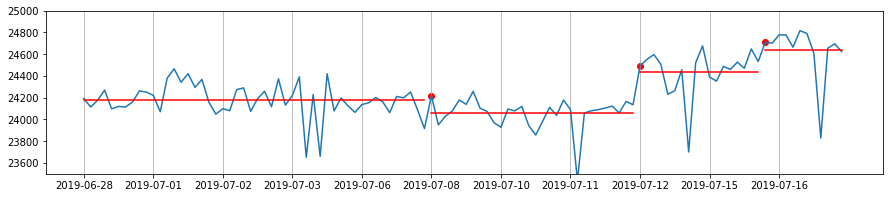

In [21]:
mean_plot.remove()
std_1_plot.remove()
std_2_plot.remove()
new_outliers.remove()

series_masked = np.ma.array(series)
series_masked.mask = np.array([False] * len(series))
series_masked.mask[outlier_indices] = True
compressed_series = series_masked.compressed()
algorithm = EDivisive()
change_points_with_mask = algorithm.compute_change_points(compressed_series)
masked_change_point_indices = [
    change_point.index +
    len([1 for item in series_masked.mask[:change_point.index] if item])
    for change_point in change_points_with_mask
]
masked_cp = ax.scatter(
    masked_change_point_indices,
    [series[point] for point in masked_change_point_indices],
    color='r'
)
means = []
prev = 0
for idx in sorted(masked_change_point_indices):
    means.append(
        ax.plot(
            range(prev, idx), [np.mean(series[prev:idx])] * (idx - prev), 'r'
        )[0]
    )
    prev = idx
means.append(
    ax.plot(
        range(idx, len(series)),
        [np.mean(series[idx:len(series)])] * (len(series) - idx), 'r'
    )[0]
)
ax.set_ylim(23500, 25000)
fig

Roughly the same as before, but without worrying much about how to configure `gesd`! Let's try another method:

### Another "New Idea"

This time, let's just compute change points on the moving average!

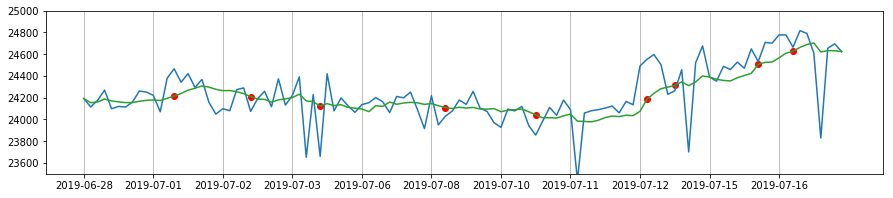

In [22]:
masked_cp.remove()
for mean in means:
    mean.remove()
rolling_mean = rolling_window.mean()
mean_plot = ax.plot(indices, rolling_mean)[0]
cps = sorted([cp.index for cp in algorithm.compute_change_points(rolling_mean)])
ax.scatter(cps, rolling_mean[cps], color='r')
fig

Hard to say on this one, which begs the question: **how do you validate that the change points we detect are "good"?**